<a href="https://colab.research.google.com/github/TheHouseOfVermeulens/Financial-Engineering/blob/master/Mean_Reversion_on_Futures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from quantopian.research.experimental import history, continuous_future
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

In [0]:
# Useful Functions
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

#Testing Artificial Examples

We'll use some artificially generated series first as they are much cleaner and easier to work with. In general when learning or developing a new technique, use simulated data to provide a clean environment. Simulated data also allows you to control the level of noise and difficulty level for your model.
##a. Cointegration Test I

Determine whether the following two artificial series  
and   are cointegrated using the `coint()` function and a reasonable confidence level.

In [0]:
A_returns = np.random.normal(0, 1, 100)
A = pd.Series(np.cumsum(A_returns), name='X') + 50

some_noise = np.random.exponential(1, 100)
 
B = A - 7 + some_noise

In [0]:
score, pvalue, _ = coint(A,B)

confidence_level = 0.05

if pvalue < confidence_level:
    print ("A and B are cointegrated")
    print pvalue
else:
    print ("A and B are not cointegrated")
    print pvalue
    
A.name = "A"
B.name = "B"
pd.concat([A, B], axis=1).plot();



```
A and B are cointegrated
6.96867595624e-15
```



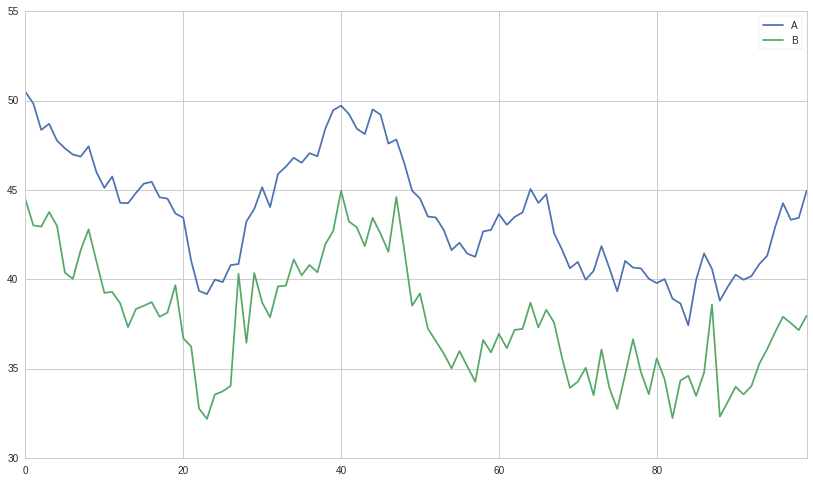

##b. Cointegration Test II

Determine whether the following two artificial series  
and   are cointegrated using the `coint()` function and a reasonable confidence level.

In [0]:
C_returns = np.random.normal(1, 1, 100) 
C = pd.Series(np.cumsum(C_returns), name='X') + 100

D_returns = np.random.normal(2, 1, 100)
D = pd.Series(np.cumsum(D_returns), name='X') + 100


C and D are not cointegrated
0.5942858667593159


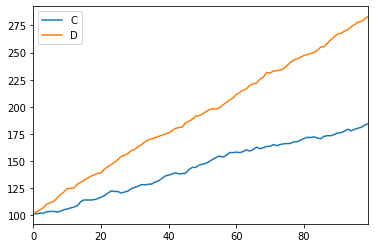

In [9]:
score, pvalue, _ = coint(C,D)

confidence_level = 0.05

if pvalue < confidence_level:
    print ("C and D are cointegrated")
    print (pvalue)
else:
    print ("C and D are not cointegrated")
    print (pvalue)

C.name = "C"
D.name = "D"
pd.concat([C, D], axis=1).plot();

#Testing Real Examples
##a. Real Cointegration Test I

Determine whether the following two assets CN and SB were cointegrated during 2015 using the `coint()` function and a reasonable confidence level.

In [0]:
cn = continuous_future('CN', offset = 0, roll = 'calendar', adjustment = 'mul')
sb = continuous_future('SB', offset = 0, roll = 'calendar', adjustment = 'mul')

cn_price = history(cn, 'price', '2015-01-01', '2016-01-01', 'daily')
sb_price = history(sb, 'price', '2015-01-01', '2016-01-01', 'daily')

In [0]:
score, pvalue, _ = coint(cn_price, sb_price)

confidence_level = 0.05

if pvalue < confidence_level:
    print ("CN and SB are cointegrated")
    print pvalue
else:
    print ("CN and SB are not cointegrated")
    print pvalue

cn_price.name = "CN"
sb_price.name = "SB"
pd.concat([cn_price, sb_price], axis=1).plot();



```
CN and SB are not cointegrated
0.605183628116
```



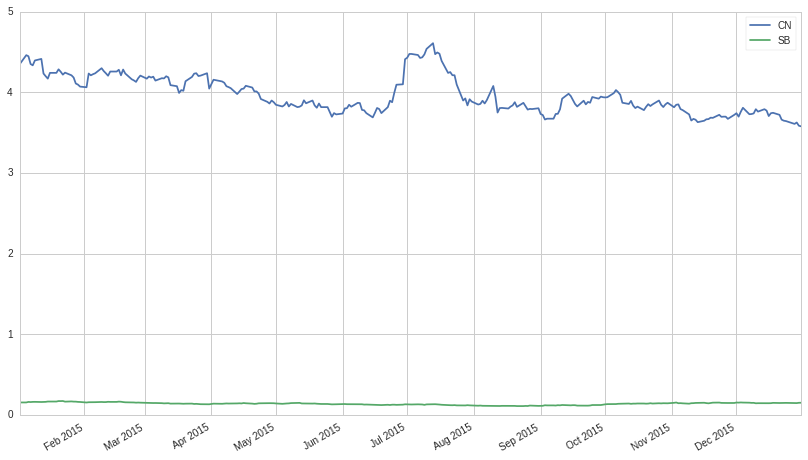


##b. Real Cointegration Test II

Determine whether the following two underlyings CL and HO were cointegrated during 2015 using the `coint()` function and a reasonable confidence level.


In [0]:
cl = continuous_future('CL', offset = 0, roll = 'calendar', adjustment = 'mul')
ho = continuous_future('HO', offset = 0, roll = 'calendar', adjustment = 'mul')

cl_price = history(cl, 'price', '2015-01-01', '2016-01-01', 'daily')
ho_price = history(ho, 'price', '2015-01-01', '2016-01-01', 'daily')

In [0]:
confidence_level = 0.05

score, pvalue, _ = coint(cl_price, ho_price)

if pvalue < confidence_level:
    print ("CL and HO are cointegrated")
    print (pvalue)
else:
    print ("CL and HO are not cointegrated")
    print (pvalue)

cl_price.name = 'CL'
ho_price.name = 'HO'
pd.concat([cl_price, ho_price.multiply(42)], axis=1).plot();



```
CL and HO are cointegrated
0.0470273399855
```



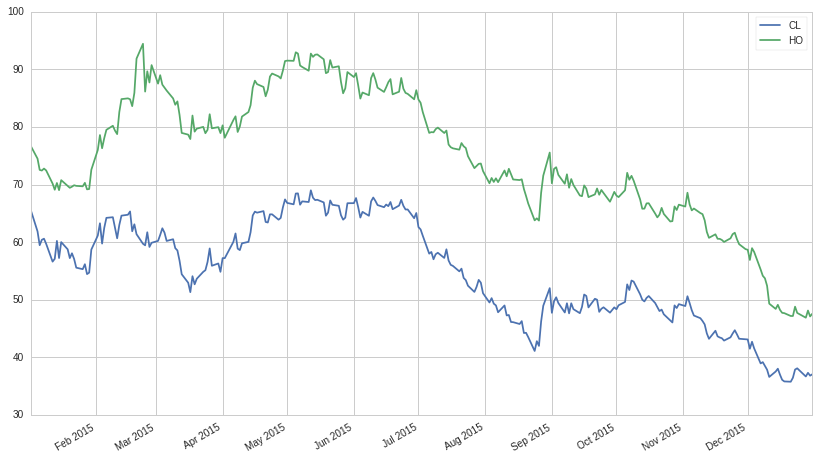

#Out of Sample Validation
##a. Calculating the Spread

Using pricing data from 2015, construct a linear regression to find a coefficient for the linear combination of CL and HO that makes their spread stationary.

In [0]:
results = sm.OLS(cl_price, sm.add_constant(ho_price)).fit()
b = results.params['HO']

print (b)
spread = cl_price - b * ho_price
print ("p-value for in-sample stationarity: ", adfuller(spread)[1])
# The p-value is less than 0.05 so we conclude that this spread calculation is stationary in sample
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);



```
30.3502596624
p-value for in-sample stationarity:  0.0124116865765
```



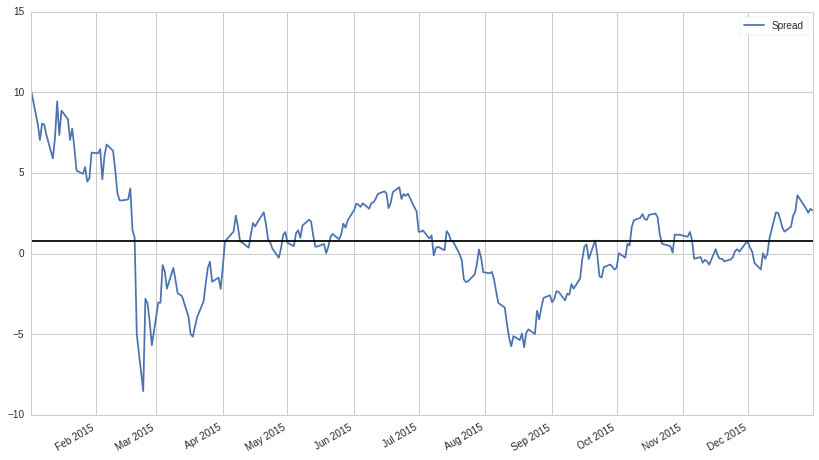


##b. Testing the Coefficient

Use your coefficient from part a to plot the weighted spread using prices from the first half of 2016, and check whether the result is still stationary.


In [0]:
cl_out = get_pricing(cl, fields='price', 
                        start_date='2016-01-01', end_date='2016-07-01')
ho_out = get_pricing(ho, fields='price', 
                        start_date='2016-01-01', end_date='2016-07-01')

In [0]:
spread = cl_out - b * ho_out
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

print ("p-value for spread stationarity: ", adfuller(spread)[1])
# Our p-value is less than 0.05 so we conclude that this calculation of
# the spread is stationary out of sample



```
p-value for spread stationarity:  0.00434011120184
```



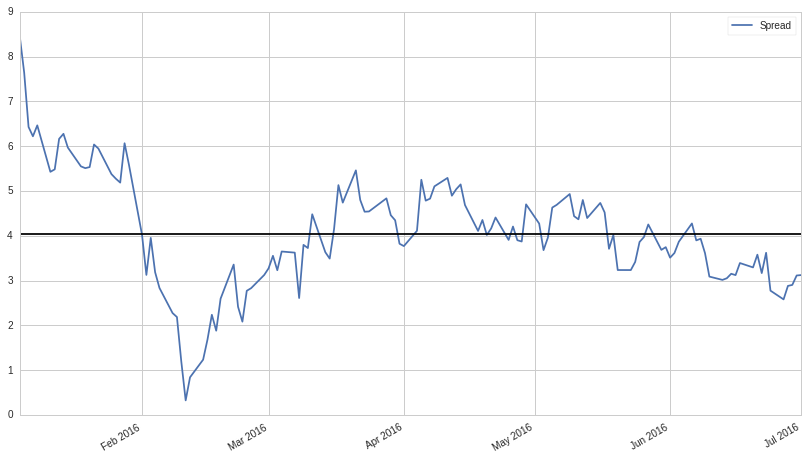